Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# Ask the Graph
# Notebook 3: Query!

In this notebook, we query the data ingested in notebook 2. We query in several ways:

- Run SPARQL queries on the knowledge graph in Amazon Neptune database
- Run searches, using OpenSearch domain-specific language, of the search index/vector store in Amazon OpenSearch Service domain
- Run natural language queries! 

Here is our data model. This notebook prepares the unstructured sources (red boxes, upper third) and extracted facts (yellow boxes, middle third).

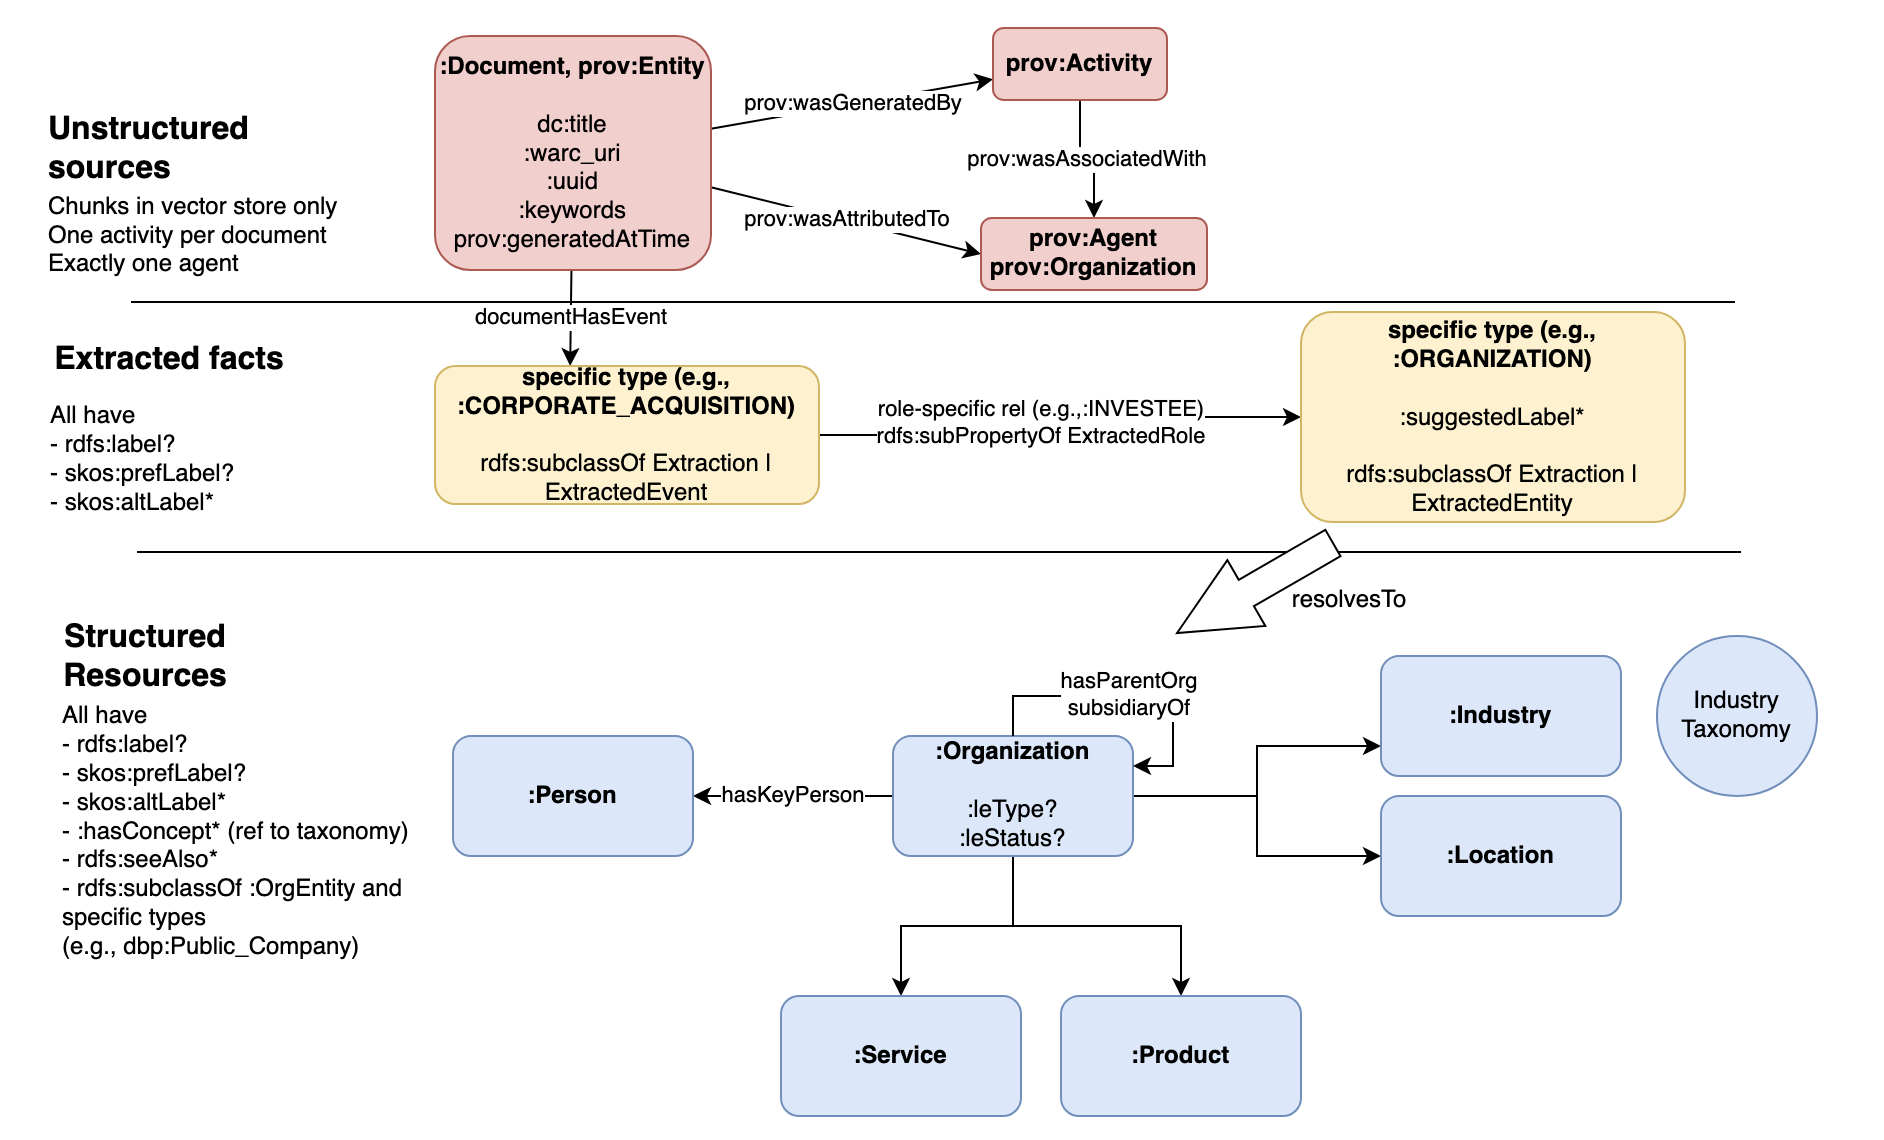

Here is how natural language queries work.

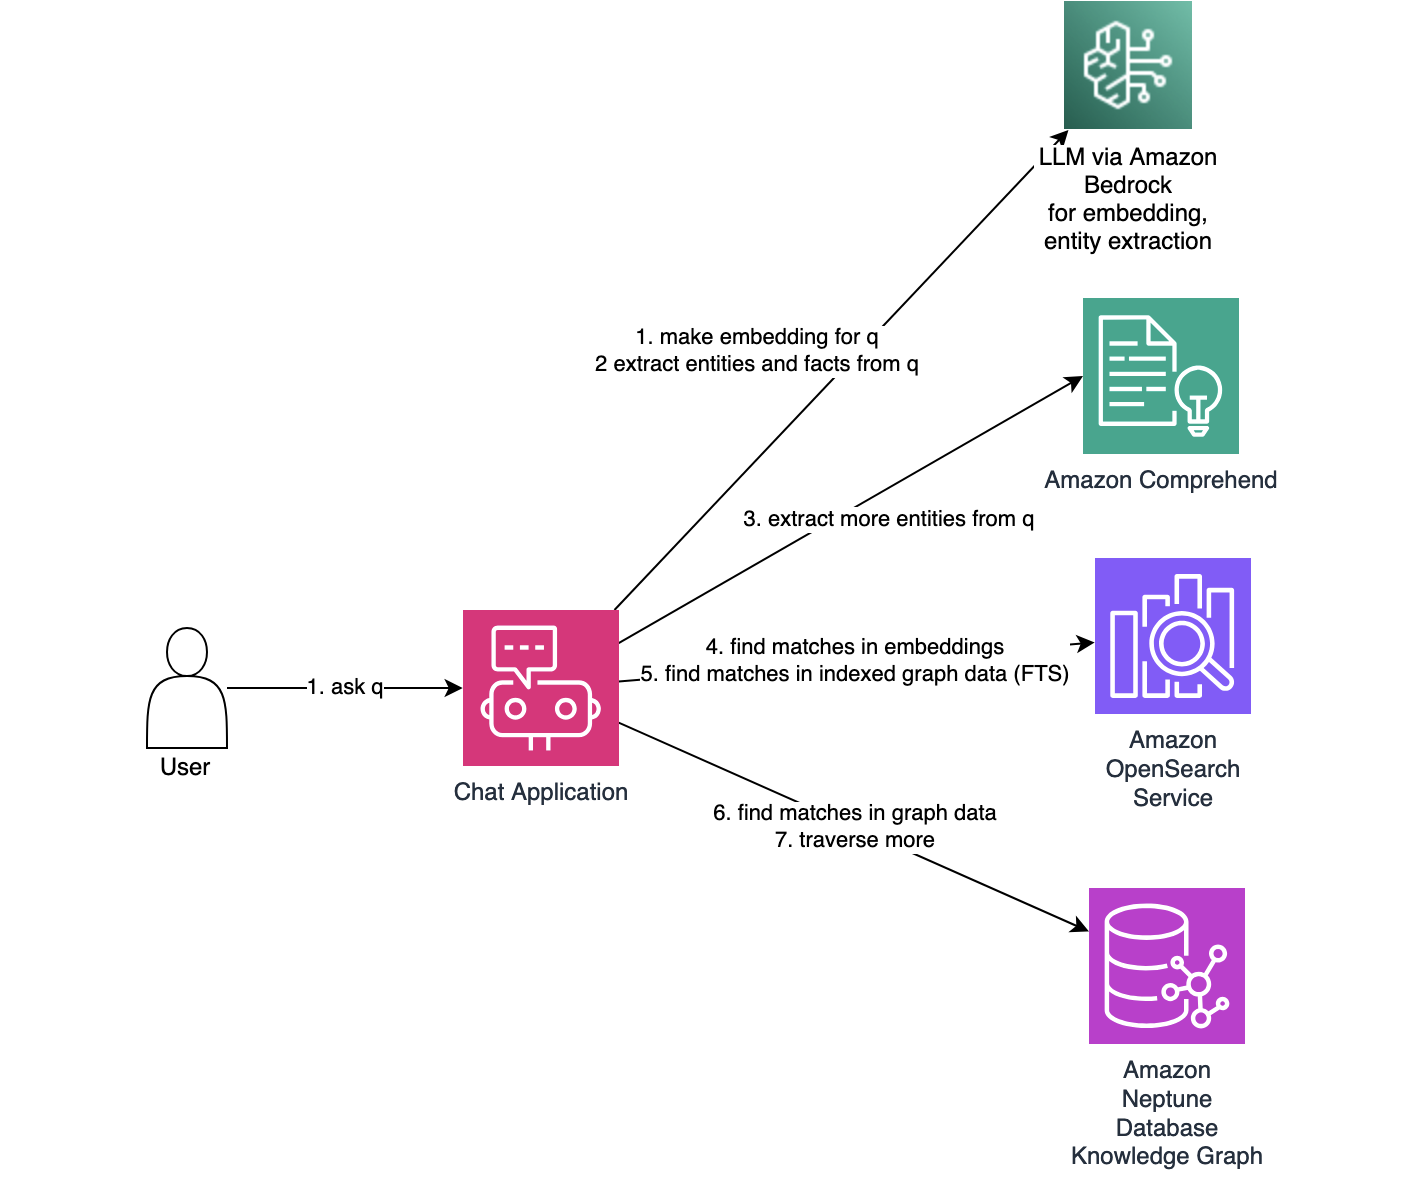

The notebook serves as a chat application, which accepts natural language questions from you, the user. We use large language models (LLMs) to extract important entities from the question, as well as to create a vector embedding of the question. We then search both the OpenSearch domain and the Neptune database for similar resources. We follow their relationships to arrive at the answer.

To run this notebook, we assume you have a Neptune cluster, an OpenSearch Service domain, an S3 staging bucket, full-text search setup to stream Neptune updates to OpenSearch. Additionally, the notebook instance must have S3, Bedrock, Neptune, and OpenSearch permissions, as well as connectivity to Neptune and OpenSearch. Refer to the README for setup instructions.

## Install a few dependencies


In [ ]:
!pip install -q opensearch-py

## Initialize

In [ ]:
import os
import boto3
import aos_helpers as aosh
import neptune_helpers as nh
import ai_helpers as aih
import query_helpers as qh
from botocore.config import Config

session=boto3.Session()

# AOS setup
AOS_ENDPOINT_HOST="<your AOS endpoint host>"

aos_client = aosh.connect_aos(AOS_ENDPOINT_HOST)

# Neptune setup
def get_neptune_env(var: str) -> str:
    return os.popen(f"source ~/.bashrc ; echo ${var}").read().split("\n")[0]

GRAPH_NOTEBOOK_HOST=get_neptune_env("GRAPH_NOTEBOOK_HOST")
GRAPH_NOTEBOOK_PORT=get_neptune_env("GRAPH_NOTEBOOK_PORT")
GRAPH_NOTEBOOK_AUTH_MODE=get_neptune_env("GRAPH_NOTEBOOK_AUTH_MODE")

neptune_conn={
    'AWS_REGION' : get_neptune_env("AWS_REGION"),
    'USE_IAM_AUTH' : GRAPH_NOTEBOOK_AUTH_MODE != "DEFAULT",
    'NEPTUNE_ENDPOINT': f"https://{GRAPH_NOTEBOOK_HOST}:{GRAPH_NOTEBOOK_PORT}/sparql"
}

# Bedrock and Comprehend setup
bedrock_client = boto3.client(service_name="bedrock-runtime")
comprehend_client = boto3.client(service_name="comprehend")

qh_client=qh.make_client(session, neptune_conn, aos_client, bedrock_client, comprehend_client)


## Run full query

In [ ]:
questions=[
    "What are the connections between ticker AMZN and John Mackey?",
    "What do Amazon, Whole Foods, Rivian and Ring have in common",
    "Did Amazon buy Whole Foods or ACME",
    "Are there any press releases about lockjaw or epidemics or Leo Gehrig's Disease or the WHO?",
    "Does amazonn have fulfilllment centers near Chicago or New Yoork, and is the WHO or the NFL a customer",
    "Tell me about Ring or Jeff Bezos",
    "Does Amazon have a fulfillment center in Mississippi?",
    "Summary deals where FAANG acquired startups",
    "What activities does AWS have going on in San Francisco?",
    "Summarize the top trends in AWS",
    "Summary deals where Amazon was investor in startups"
    "Describe job retraining programs",
    "Which companies have a lot of products and services?",
    "Name some cloud companies"
]

question=questions[-1]
print(question)

results=qh.answer_question(qh_client, question)

qh.render_results_json_file("test1.json", results)

# A RAG answer - LLM summarizes our results
qh.render_results_llm_summary(qh_client, 'testsummary1.txt', question, results)


In [ ]:
qh.render_results_llm_summary(qh_client, 'testsummary1.txt', question, results)

## Test query parts
### Chunk matches

### Analyze question

### Find entities in AOS

### Find entities in Neptune

### Connect entities in Neptune